In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import generate_objects, BunchTracker, track, compare_traces, compare_projections, Machine

from PyHEADTAIL_feedback.feedback import OneboxFeedback, Kicker, PickUp
from PyHEADTAIL_feedback.processors import ChargeWeighter, Averager, Bypass
from PyHEADTAIL_feedback.digital_processors import HilbertPhaseShiftRegister

np.random.seed(0)

PyHEADTAIL v1.9.4




In [2]:
""" 
    In this example, a feedback system consisting of multiple pickups and kickers is demonstrated. It differs
    very little from the previous example (002_separated_pickup_and_kicker), but it might look like messy
    because multiple pickup and kickers must be determined.
    
"""

u' \n    In this example, a feedback system consisting of multiple pickups and kickers is demonstrated. It differs\n    very little from the previous example (002_separated_pickup_and_kicker), but it might look like messy\n    because multiple pickup and kickers must be determined.\n    \n'

In [3]:
# basic parameters of the simulation
n_macroparticles = 10000
n_slices = 20
n_segments = 5
n_sigma_z = 3 

n_turns = 400

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(n_macroparticles,n_segments, n_slices,n_sigma_z)
bunch_unkicked = copy.deepcopy(bunch_ref)


In [4]:
# this creates an artificially kicked bunch, which will be damped with different feedback systems

slice_set = bunch_ref.get_slices(slicer_ref, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

# random kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]
    
bunch_init = copy.deepcopy(bunch_ref)
tracker_ref = BunchTracker(bunch_init)
maps_ref = [i for i in trans_map] + [long_map]
track(n_turns, bunch_init,maps_ref,tracker_ref)

# The machine parameters have been determined in Machine() object in file test_tools.py
machine = Machine()

In [5]:
# In the used code, the parameter 'gain' is determined as a fraction of the input signal if the used signal 
# processors would bypass the signalperfectly

# There are two ways to set a gain value. If only one value is given, same value will be used both
# in horizontal and vertical plane. If two values are given, separed values (x,y) are used for horizontal and
# vertical planes

feedback_gain = 0.01
# feedback_gain = (0.01,0.01)

delay = 1 
n_values = 3


xp_per_x = bunch_unkicked.sigma_xp()/bunch_unkicked.sigma_x()
yp_per_y = bunch_unkicked.sigma_yp()/bunch_unkicked.sigma_y()

In [6]:
# A reference feedback system for examples presented in this file is the ideal bunch feedback presented in 
# file 001_ideal_feedbacks.ipynb:

bunch_OneBox_bunch = copy.deepcopy(bunch_ref)
tracker_OneBox_bunch = BunchTracker(bunch_OneBox_bunch)
slicer_OneBox_bunch = copy.deepcopy(slicer_ref)

processors_bunch_x = [
    ChargeWeighter(normalization = 'average_weight'),
    Averager()
]
processors_bunch_y = [
    ChargeWeighter(normalization = 'average_weight'),
    Averager()
]

# Because two kickers are used in the example, two times higher gain must be used in this reference system
feedback_map = OneboxFeedback(2.*feedback_gain,slicer_OneBox_bunch,processors_bunch_x,processors_bunch_y)
total_map_OneBox_bunch = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_OneBox_bunch,total_map_OneBox_bunch,tracker_OneBox_bunch)

# That feedback system is extended to consist of separated pickup and kicker in this file. If you don't
# understand details of the code above, please study examples in 001_ideal_feedbacks.ipynb

400 elements is calculated
400 elements is calculated


In [7]:
bunch_multi_object = copy.deepcopy(bunch_ref)
tracker_multi_object = BunchTracker(bunch_multi_object)
slicer_multi_object = copy.deepcopy(slicer_ref)



In [8]:
# Three pickups are created in this cell. Exactly same code is used for creating a pickup, as presented in 
# previous example (002_separated_pickup_and_kicker.ipynb).

# Pickups can be set to any location in the accelerator, but the location must be between two maps elements
# in PyHEADTAIL transverse map. In this example, it was chosen that pickups are after first, second and third
# elements of trans_map. Trans_map divides the accelerator to a number of segments determined in 
# the variable 'n_segments'

##############
## Pickup 1 ##
##############
processors_pickup_1_x = [
    ChargeWeighter(normalization = 'average_weight'),
    Averager(),
    HilbertPhaseShiftRegister(n_values, machine.Q_x, delay)
]
processors_pickup_1_y = [
    ChargeWeighter(normalization = 'average_weight'),
    Averager(),
    HilbertPhaseShiftRegister(n_values, machine.Q_y, delay)
]

# The total betatron phase angle over the accelerator is 2*pi*Q. In this example, the accelerator is divided
# into a number of equally length segments determined by 'n_segments'. Thus, a length of the one segment in
# betatron phase is 2*pi*Q/n_segments. The location of the pickup is after the first segment, so this number 
# is multiplied by one.

pickup_1_position_x = 1.*2.*pi/float(n_segments)*machine.Q_x
pickup_1_position_y = 1.*2.*pi/float(n_segments)*machine.Q_y

pickup_1_map = PickUp(slicer_multi_object,
                    processors_pickup_1_x,processors_pickup_1_y, 
                    pickup_1_position_x, pickup_1_position_y)


##############
## Pickup 2 ##
##############
processors_pickup_2_x = [
    ChargeWeighter(normalization = 'average_weight'),
    Averager(),
    HilbertPhaseShiftRegister(n_values, machine.Q_x, delay)
]
processors_pickup_2_y = [
    ChargeWeighter(normalization = 'average_weight'),
    Averager(),
    HilbertPhaseShiftRegister(n_values, machine.Q_y, delay)
]
pickup_2_position_x = 2.*2.*pi/float(n_segments)*machine.Q_x
pickup_2_position_y = 2.*2.*pi/float(n_segments)*machine.Q_y

pickup_2_map = PickUp(slicer_multi_object,
                    processors_pickup_2_x,processors_pickup_2_y, 
                    pickup_2_position_x, pickup_2_position_y)


##############
## Pickup 3 ##
##############
processors_pickup_3_x = [
    ChargeWeighter(normalization = 'average_weight'),
    Averager(),
    HilbertPhaseShiftRegister(n_values, machine.Q_x, delay)
]
processors_pickup_3_y = [
    ChargeWeighter(normalization = 'average_weight'),
    Averager(),
    HilbertPhaseShiftRegister(n_values, machine.Q_y, delay)
]
pickup_3_position_x = 3.*2.*pi/float(n_segments)*machine.Q_x
pickup_3_position_y = 3.*2.*pi/float(n_segments)*machine.Q_y

pickup_3_map = PickUp(slicer_multi_object,
                    processors_pickup_3_x,processors_pickup_3_y, 
                    pickup_3_position_x, pickup_3_position_y)

In [9]:
# Two kickers are created in this cell. Exactly same code is used as presented in previous example 
# (002_separated_pickup_and_kicker.ipynb), expect references of multiple pickups are given as an input 
# parameter.
#
# Also kickers can be set to any location in the accelerator, but the location must be between two maps 
# elements in PyHEADTAIL transverse map. In this example, it was chosen that the kickers are located after 
# second and fourth transfer map elements. Furthermore, it was chosen that Kicker 1 utilizes signals from 
# pickups 1 and 2 and Kicker 2 utilizes signals from pickups 1 and 3.

##############
## Kicker 1 ##
##############
processors_kicker_1_x = [Bypass()]
processors_kicker_1_y = [Bypass()]

registers_kicker_1_x = [
    processors_pickup_1_x[2],
    processors_pickup_2_x[2]
]
registers_kicker_1_y = [
    processors_pickup_1_y[2],
    processors_pickup_2_y[2]
]

kicker_1_position_x = 2.*2.*pi/float(n_segments)*machine.Q_x
kicker_1_position_y = 2.*2.*pi/float(n_segments)*machine.Q_y

kicker_1_map = Kicker(feedback_gain, slicer_multi_object,
                    processors_kicker_1_x, processors_kicker_1_y,
                    kicker_1_position_x, kicker_1_position_y,
                    registers_kicker_1_x, registers_kicker_1_y, 
                    xp_per_x, yp_per_y)

##############
## Kicker 2 ##
##############
processors_kicker_2_x = [Bypass()]
processors_kicker_2_y = [Bypass()]

registers_kicker_2_x = [
    processors_pickup_1_x[2],
    processors_pickup_3_x[2]
]
registers_kicker_2_y = [
    processors_pickup_1_y[2],
    processors_pickup_3_y[2]
]

kicker_2_position_x = 4.*2.*pi/float(n_segments)*machine.Q_x
kicker_2_position_y = 4.*2.*pi/float(n_segments)*machine.Q_y

kicker_2_map = Kicker(feedback_gain, slicer_multi_object,
                    processors_kicker_2_x, processors_kicker_2_y,
                    kicker_2_position_x, kicker_2_position_y,
                    registers_kicker_2_x, registers_kicker_2_y, 
                    xp_per_x, yp_per_y)


In [10]:
# After that the maps must be added to correct slots of the total map determined by the positions of 
# the picups and the kickers
total_map_multi_object = [trans_map[0]] + [pickup_1_map] + [trans_map[1]] + [pickup_2_map] + [kicker_1_map] + [trans_map[2]]+ [pickup_3_map] + [trans_map[3]] + [kicker_2_map]
for element in trans_map[4:]:
    total_map_multi_object += [element]
total_map_multi_object += [long_map]
    
    
track(n_turns, bunch_multi_object,total_map_multi_object,tracker_multi_object)

400 elements is calculated
400 elements is calculated
400 elements is calculated
400 elements is calculated
400 elements is calculated
400 elements is calculated


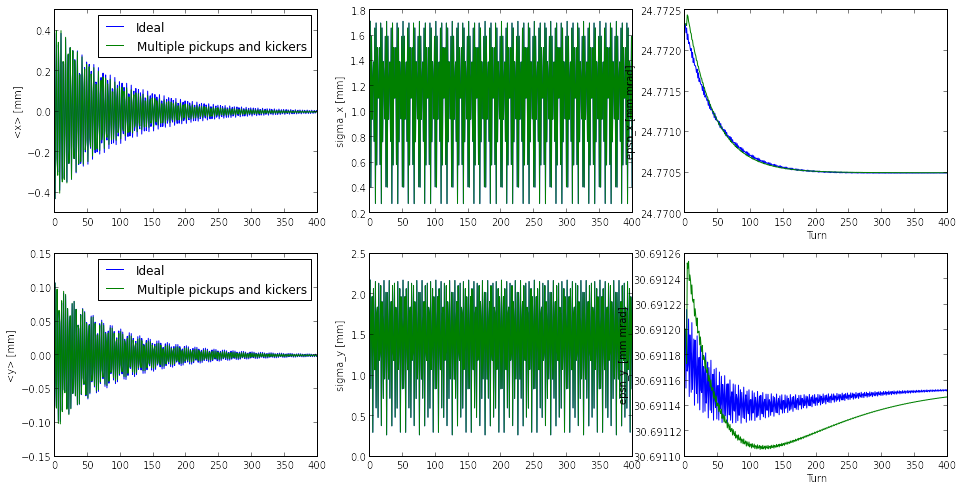

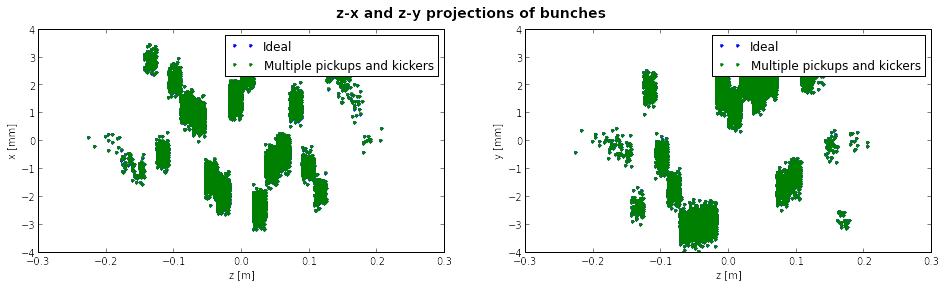

In [11]:
# In here, the traces and the projections from different implementations of the feedback system are compared.
# Note the scale in the emittance figures.

compare_traces([tracker_OneBox_bunch,tracker_multi_object],
               ['Ideal', 'Multiple pickups and kickers'])
compare_projections([ bunch_OneBox_bunch,  bunch_multi_object], 
                    ['Ideal', 'Multiple pickups and kickers'])